# 1.0 Set Similarity Analysis - Transcriptional factors and MultiFun Terms

- **Data:**
    - **MultiFun:** The MultiFun ontology assigns genes to ontology classes based on the function of the gene product.
    > **Abstract (full article [here](https://pubmed.ncbi.nlm.nih.gov/11471834/))**  
    > An enriched classification system for cellular functions of gene products of Escherichia coli K-12 was developed based on the initial classification by Riley. In the new classification scheme, MultiFun, cellular functions are divided into 10 major categories: Metabolism, Information Transfer, Regulation, Transport, Cell Processes, Cell Structure, Location, Extra-chromosomal Origin, DNA Site, and Cryptic Gene. These major categories are further sub-divided into a hierarchical scheme.
    - **Tf-Gene network:**  
        The interaction file only needs to contain a column of **source** nodes and **target** nodes. The interaction file only needs to contain a column of exit nodes and arrival nodes. However, it may contain more information that can be useful for filtering the results.  
          
        The file used in this document contains the following columns and can be found [here](http://regulondb.ccg.unam.mx/menu/download/datasets/files/network_tf_gene.txt).
        1. Transcription Factor (TF) name.
        2. Gene regulated by the TF (regulated gene).
        3. Regulatory effect of the TF on the regulated gene (+ activator, - repressor, +- dual, ? unknown).
        4. Evidence that supports the existence of the regulatory interaction.
        5. Evidence Type [Weak, Strong, Confirmed] For details see: http://regulondb.ccg.unam.mx/evidenceclassification
  
  
- **Objetive:** Since the functions in **MultiFun terms are hierarchical**, the goal of this notebook is to associate a level of similarity by comparing each level of specificity with its peer, in addition to functional similarity without considering any hierarchy.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from pyprojroot import here
from IPython.display import Image

## Run setup

[Go to setup notebook.](./../0.3-jvs-setup.ipynb)

In [2]:
setup_file = here("notebooks").joinpath("0.3-jvs-setup.ipynb")
%run $setup_file

## Load data

The first thing is to define where our data resource is located. Since it is data provided by another team, it must be placed in the external data folder.

In [3]:
data_dir = datadir("external"); data_dir.exists()

True

### Multifun terms

In [4]:
multifun_dir = data_dir.joinpath("multifun"); multifun_dir.exists()

True

In [5]:
multifun_file = multifun_dir.joinpath("gene_GenProtEC.txt"); multifun_file.exists()

True

In [6]:
multifun_df = pd.read_csv(
    filepath_or_buffer=multifun_file,
    sep="\t",
    comment="#",
    names=["node", "terms"],
    index_col=0
)
print(multifun_df.shape)
multifun_df.head()

(6569, 1)


,terms
node,
aaeA,4 --> transport
aaeA,6 --> cell structure 6.1 --> membrane
aaeB,4 --> transport
aaeB,6 --> cell structure 6.1 --> membrane
aaeR,2 --> information transfer 2.2 --> RNA related...


### Interactions network

In [7]:
networkds_dir = data_dir.joinpath("networks"); networkds_dir.exists()

True

In [8]:
interactions_file = networkds_dir.joinpath("network_tf_gene.txt"); interactions_file.exists()

True

In [9]:
interactions_df = pd.read_csv(
    filepath_or_buffer=interactions_file,
    sep="\t",
    comment="#",
    names=["source", "target", "regulatory_effect", "evidence", "evidence_type"]
)
print(interactions_df.shape)
interactions_df.head()

(4670, 5)


,source,target,regulatory_effect,evidence,evidence_type
0,AccB,accB,repressor,"[GEA, IMP]",Weak
1,AccB,accC,repressor,"[GEA, IMP]",Weak
2,AcrR,acrA,repressor,"[APIORCISFBSCS, BCE, BPP, GEA]",Strong
3,AcrR,acrB,repressor,"[APIORCISFBSCS, BCE, BPP, GEA]",Strong
4,AcrR,acrR,repressor,"[AIBSCS, APIORCISFBSCS, BCE, BPP, GEA]",Strong


## Preprocessing

### Multifun data

#### Separate identifier and definition

**Exaple of lines to parse:**

> - 3 --> regulation 3.1 --> type of regulation 3.1.2 --> transcriptional level 
> - 4 --> transport 4.2 --> Electrochemical potential driven transporters 4.2.A --> Porters (Uni-, Sym- and Antiporters)
  
**Regular expression to use:**  
>(\d+(?:\\.[\S]+)*) --> (.+?)(?:(?=(?:\d+(?:\.[\S]+)*))|$)
  
**Explanation:**

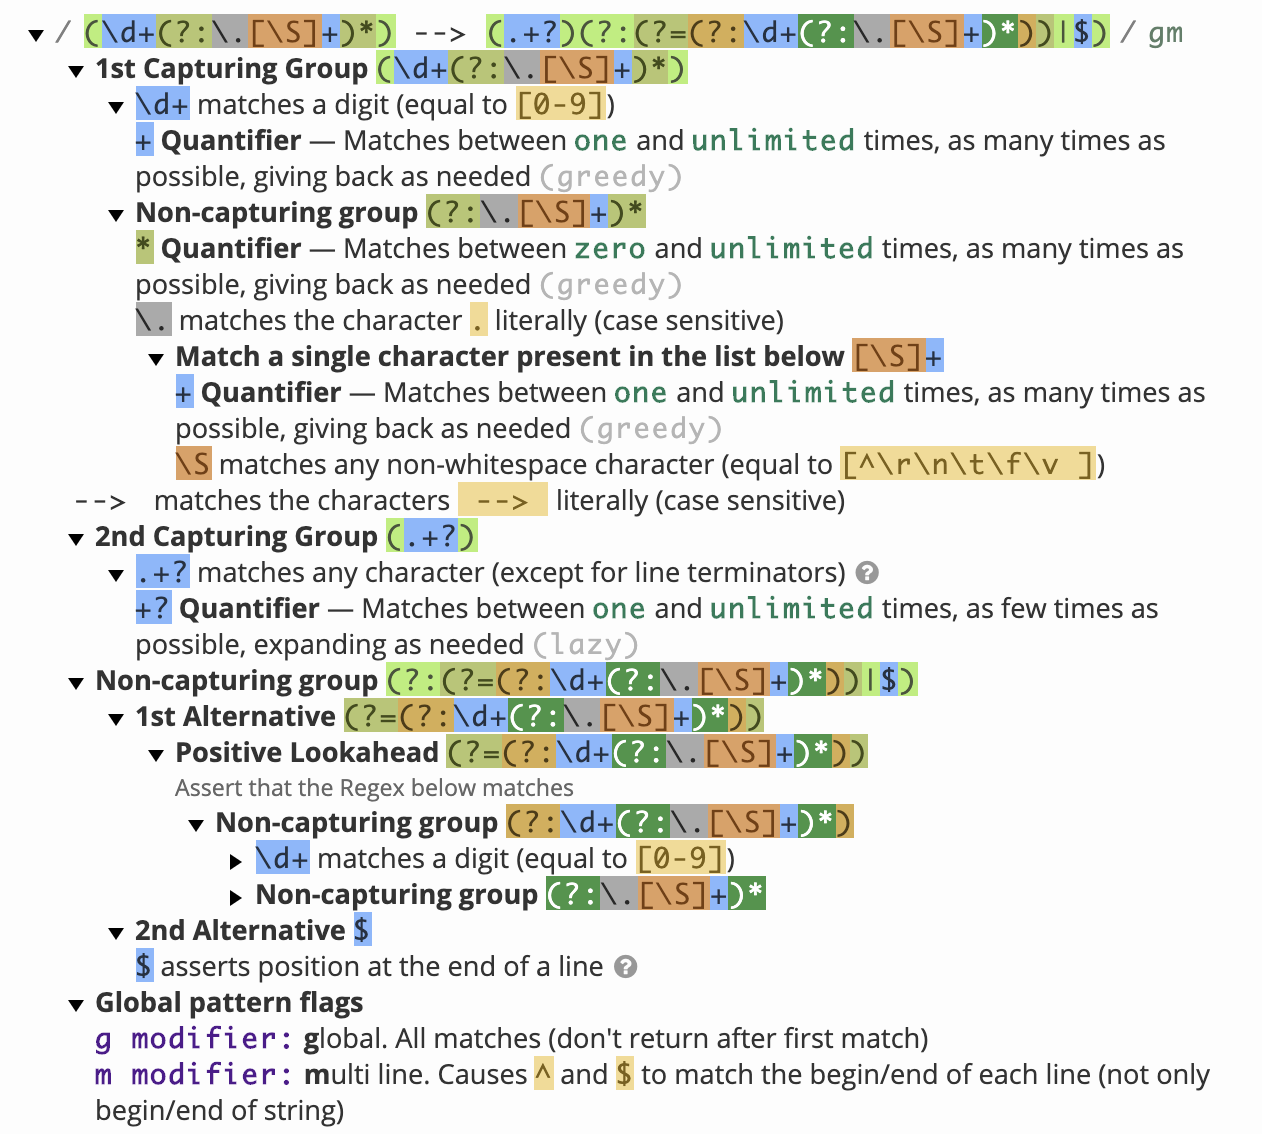

In [10]:
Image(figuresdir("regex_multifon_explanation.png"), width=600)

In [11]:
id_regex = r"\d+(?:\.[\S]+)*"
id_def_regex = r"({}) --> (.+?)(?:(?=(?:{}))|$)".format(id_regex, id_regex)

The first thing is to apply our regular expression to extract all the matches for what we want to identify: the id and the definition for each of these. Subsequently we remove those blank spaces that may be unnecessary. We rename the columns and that's it.

In [12]:
tidy_multifun_df = (
    multifun_df["terms"].
    str.extractall(id_def_regex).
    apply(lambda x: x.str.strip()).
    reset_index().
    rename(columns={"match": "specificity_level", 0:"id", 1:"def"})
)

tidy_multifun_df.head()

,node,specificity_level,id,def
0,aaeA,0,4,transport
1,aaeA,0,6,cell structure
2,aaeA,1,6.1,membrane
3,aaeB,0,4,transport
4,aaeB,0,6,cell structure


#### Create DF of sets to apply jaccard index by specificity level for each node

Given that in the previous section the functions of each node were achieved at each level of specificity, what will be done next is the creation of the sets of functions associated with their level of specificity for each node. In this way we can use these nested sets to perform the similarity functions.

In [13]:
nodes_functions_df = (
    tidy_multifun_df[["node", "specificity_level", "def"]].
    groupby(by=["node", "specificity_level"]). # For each node and its levels of specificity we group its functional identifiers. 
    aggregate(set).
    reset_index().
    groupby("node"). # Then once we have all the sets of functions at each specificity level for each node, we will group those sets in a dictionary.
    aggregate(list).
    assign(
        functions_by_specificity = lambda df: 
            df.apply(lambda row: dict(zip(row["specificity_level"], row["def"])), axis=1)
    ).
    drop(columns=["specificity_level", "def"]).
    assign(max_specificity_level=lambda df: df.functions_by_specificity.apply(len) - 1).
    reset_index()
)

nodes_functions_df.head()

,node,functions_by_specificity,max_specificity_level
0,aaeA,"{0: {'transport', 'cell structure'}, 1: {'memb...",1
1,aaeB,"{0: {'transport', 'cell structure'}, 1: {'memb...",1
2,aaeR,"{0: {'cell processes', 'information transfer',...",3
3,aas,"{0: {'cell structure', 'information transfer',...",2
4,aat,"{0: {'information transfer', 'metabolism'}, 1:...",2


### Interactions data

The interactions file used in this notebook contains different columns that could be interesting when filtering the data, for example, the evidence column could be used and thus leave only those interactions with strong evidence. However, for generality purposes all records were kept.

In [14]:
filtered_interactions_df = interactions_df[["source", "target"]]

### Combine data sources

Now that we have both sets of data ready, functions and interactions, what follows is to combine them. To combine them, we start from the premise that, in principle, the functions of a transcriptional factor are associated with the genes it regulates. Therefore, the column of target nodes (_i.e_ genes regulated by a tf) of the interaction file is used in conjunction with the column of nodes of the function data. In this way, a set of functions associated with all the genes it regulates is associated for each tf in the interaction file. It is noteworthy that these functions are collapsed by hierarchical level.

In [15]:
tf_functions_df = (
    pd.merge(
        filtered_interactions_df,
        nodes_functions_df,
        left_on=["target"],
        right_on=["node"]
    ).
    drop(columns=["target", "node", "max_specificity_level"]).
    groupby(by="source").
    aggregate(merge_iter_dicts).
    assign(max_specificity_level = lambda df: df["functions_by_specificity"].apply(len) - 1)
)

tf_functions_df.head()

,functions_by_specificity,max_specificity_level
source,,
AccB,"{0: {'metabolism'}, 1: {'biosynthesis of macro...",3
AcrR,"{0: {'cell processes', 'information transfer',...",3
Ada,"{0: {'information transfer', 'regulation'}, 1:...",3
AdiY,"{0: {'cell processes', 'transport', 'informati...",3
AgaR,"{0: {'transport', 'information transfer', 'reg...",3


## Analysis

Now that we have the basic characteristic functions per **TF**, we can proceed to carry out a **functional similarity analysis** based on **nested MultiFun terms** using some set similarity metric, in our case, **jaccard index**.

>**Note:** The following is the declaration of partial functions using the `functools.partial` function, which allows us to define the default values of our new function, which makes it easier for us to call new functions only with the arguments that, it is known, they want to modify.

### Partial functions

#### Jaccard index

Given that the data set that we want to study is the same and that what we want to study is the change in the results depending on the similarity metric, the following values of the `jaccard_df` function are chosen as default:

- **df**=tf_functions_df. # Data to analyze.
- **set_colum**="functions_by_specificity". # Which column contains the sets to compare?.
- **matrix**=True. # Should the result be delivered in a long or wide format?
- **labels**=["source", "target"]. # Names of the output columns, or pivot columns.
- **global_label**="". # Should a score be calculated without considering subsets? What name should this column have?
- **not_key_return**=-1. # In the event that, at the same level, information from at least one of the sets to be compared is unknown, the desired value returns.

So you can play around with the remaining parameters when you call the function:

- **B:** Use the Cartesian product of the dataframe index in conjunction with the supplied values.
- **kwargs:** Extra arguments to pass to the `jaccard` function.

> For more help, in any function you can go to the notebook `0.3-jvs-setup.ipynb`, or call the `help` function to the `object of interest` to obtain its **documentation**.
>
> Example: 
>
>```python
>help(jaccard_df)
>help(jaccard)
>```

In [16]:
similarity_partial_df = functools.partial(
    nested_jaccard_df,
    df=tf_functions_df,
    set_column="functions_by_specificity",
    labels=["Source", "Target"],
    global_label="global_score",
    not_key_return=-1,
    matrix=True
)

#### Clustermap

To keep all the plots to a standard. Feel free to modify this or even not use a partial function so that each graph is different. This is because, in general, if the number of elements in a heatmap is different or the labels are of different sizes, the visualization could be improved with these changes.

In [17]:
clustermap = functools.partial(
    sns.clustermap,
    xticklabels=True,
    yticklabels=True,
    figsize=(10,10)
)

### Clustering by similarity

#### Simple jaccard

In [18]:
simple_jaccard = similarity_partial_df()
simple_jaccard.head()

global_score                                                    \
Target         AccB      AcrR       Ada      AdiY      AgaR      AidB   
Source                                                                  
AccB       1.000000  0.055556  0.000000  0.074074  0.050000  0.000000   
AcrR       0.055556  1.000000  0.294118  0.447368  0.236842  0.125000   
Ada        0.000000  0.294118  1.000000  0.346154  0.350000  0.333333   
AdiY       0.074074  0.447368  0.346154  1.000000  0.266667  0.125000   
AgaR       0.050000  0.236842  0.350000  0.266667  1.000000  0.266667   

                                                ...    4                      \
Target      AlaS      AllR      AllS      AlsR  ... YefM YefM-YoeB YeiL YhaJ   
Source                                          ...                            
AccB    0.000000  0.035714  0.100000  0.035714  ... -1.0      -1.0 -1.0 -1.0   
AcrR    0.147059  0.341463  0.027778  0.309524  ... -1.0      -1.0 -1.0 -1.0   
Ada     0.357143  0.250000  0.000000  0.346154  ... -1.0      -1.0 -1.0 -1.0   
AdiY    0.153846  0.483871  0.120000  0.352941  ... -1.0      -1.0 -1.0 -1.0   
AgaR    0.294118  0.407407  0.111111  0.461538  ... -1.0      -1.0 -1.0 -1.0   

                                      
Target YiaJ YjjQ YqhC ZntR ZraR  Zur  
Source                                
AccB   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
AcrR   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
Ada    -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
AdiY   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
AgaR   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  

[5 rows x 1266 columns]

In [19]:
matrix_labels = simple_jaccard.columns.get_level_values(0).unique()
matrix_labels

Index(['global_score', 0, 1, 2, 3, 4], dtype='object')

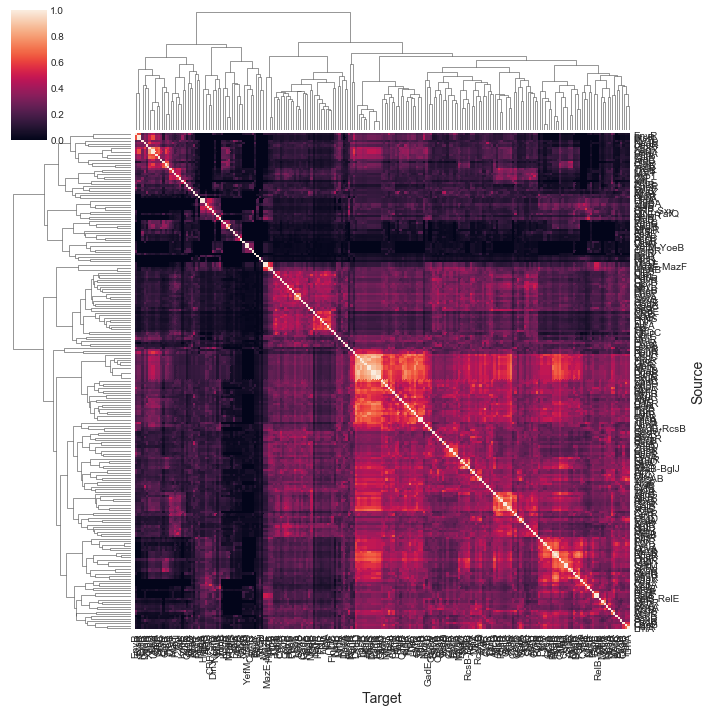

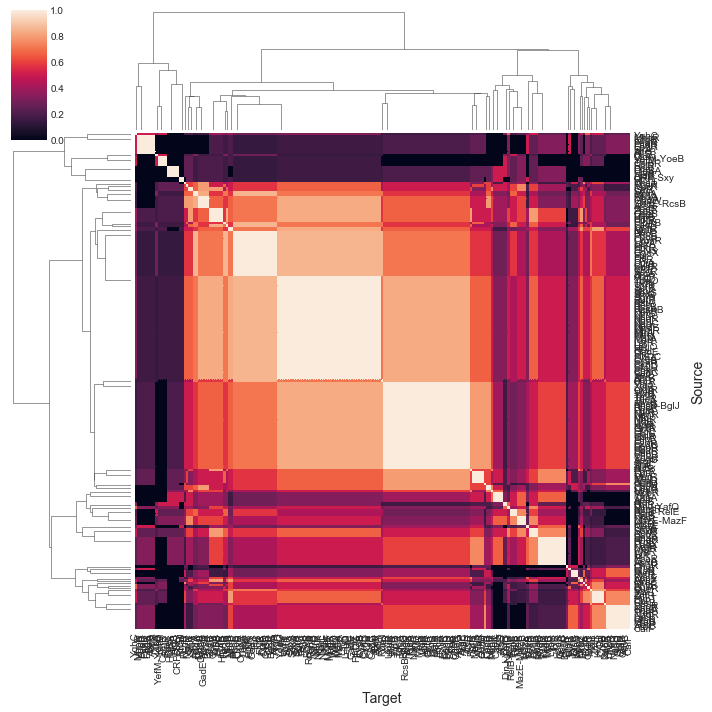

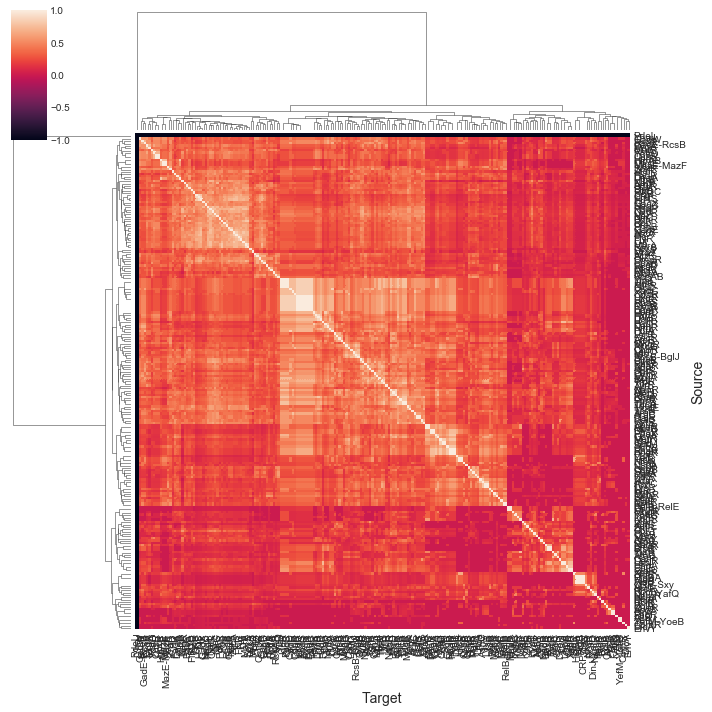

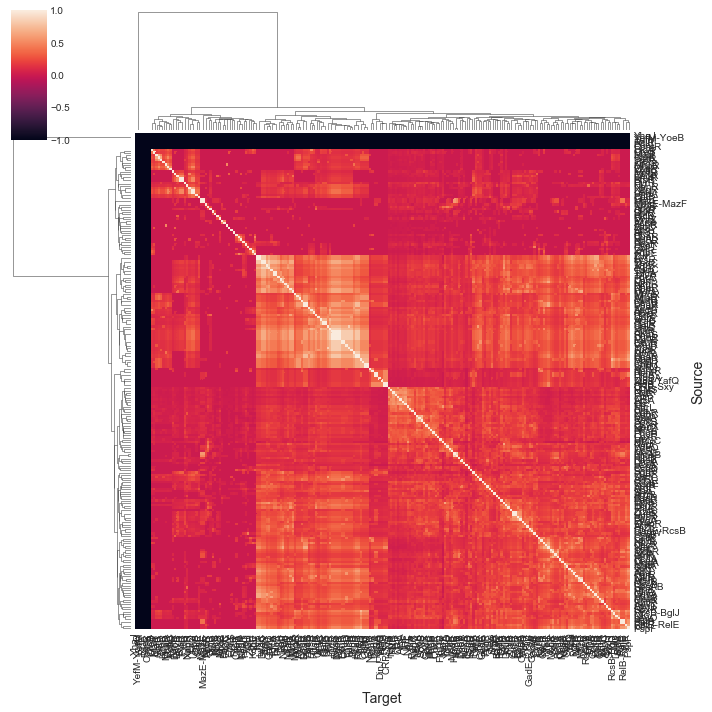

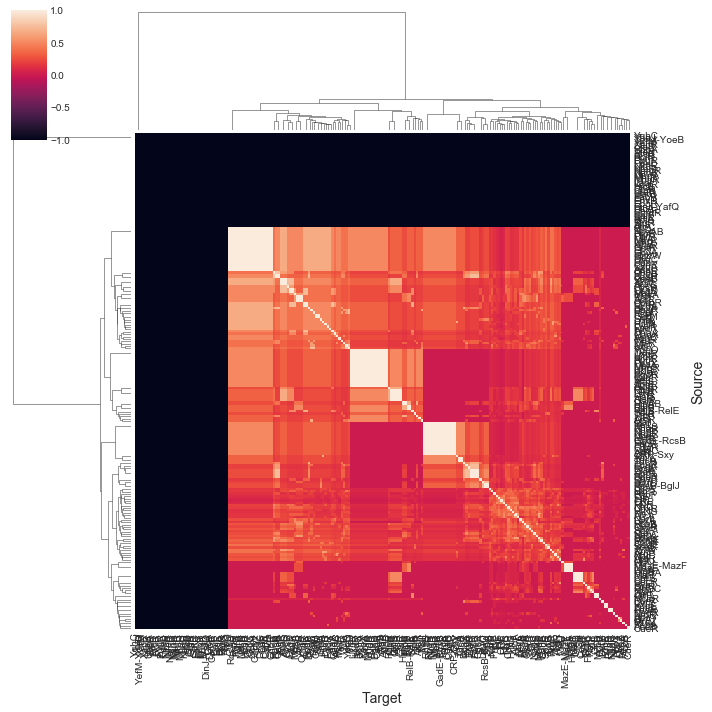

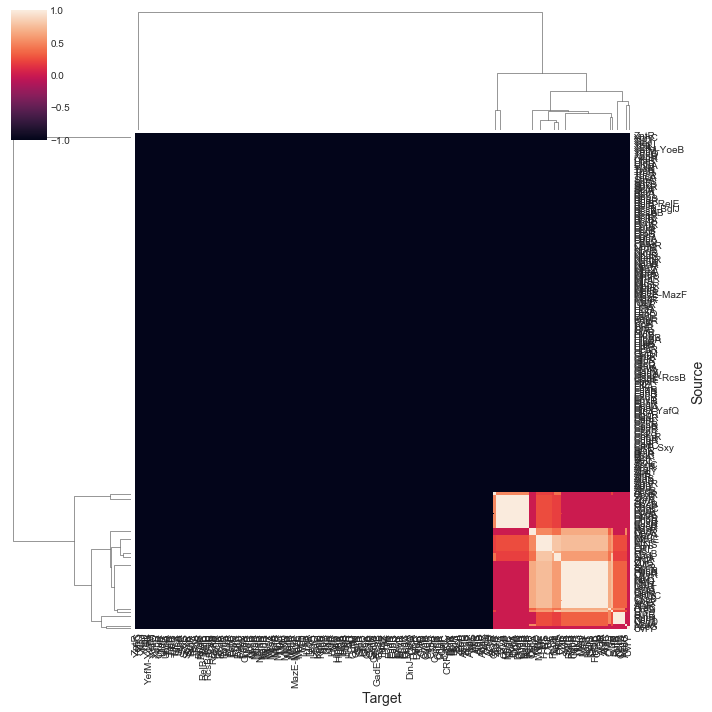

In [20]:
for matrix_label in matrix_labels:
    clustermap(simple_jaccard[matrix_label])

#### Modified jaccard

In [21]:
modified_jaccard = similarity_partial_df(modified=True)
modified_jaccard.head()

global_score                                                          \
Target         AccB      AcrR       Ada      AdiY      AgaR  AidB      AlaS   
Source                                                                        
AccB       1.000000  0.333333  0.000000  0.333333  0.166667  0.00  0.000000   
AcrR       0.333333  1.000000  0.833333  0.739130  0.600000  1.00  0.714286   
Ada        0.000000  0.833333  1.000000  0.750000  0.583333  1.00  0.714286   
AdiY       0.333333  0.739130  0.750000  1.000000  0.533333  0.75  0.571429   
AgaR       0.166667  0.600000  0.583333  0.533333  1.000000  1.00  0.714286   

                                 ...    4                                     \
Target      AllR AllS      AlsR  ... YefM YefM-YoeB YeiL YhaJ YiaJ YjjQ YqhC   
Source                           ...                                           
AccB    0.166667  0.2  0.166667  ... -1.0      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
AcrR    0.608696  0.2  0.565217  ... -1.0      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
Ada     0.583333  0.0  0.750000  ... -1.0      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
AdiY    0.652174  0.6  0.521739  ... -1.0      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
AgaR    0.733333  0.4  0.800000  ... -1.0      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   

                       
Target ZntR ZraR  Zur  
Source                 
AccB   -1.0 -1.0 -1.0  
AcrR   -1.0 -1.0 -1.0  
Ada    -1.0 -1.0 -1.0  
AdiY   -1.0 -1.0 -1.0  
AgaR   -1.0 -1.0 -1.0  

[5 rows x 1266 columns]

In [22]:
matrix_labels = simple_jaccard.columns.get_level_values(0).unique()
matrix_labels

Index(['global_score', 0, 1, 2, 3, 4], dtype='object')

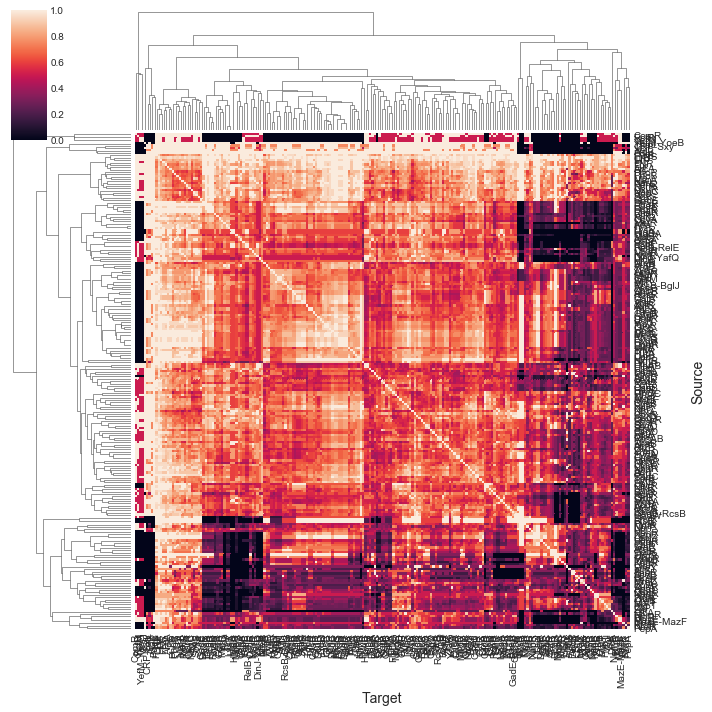

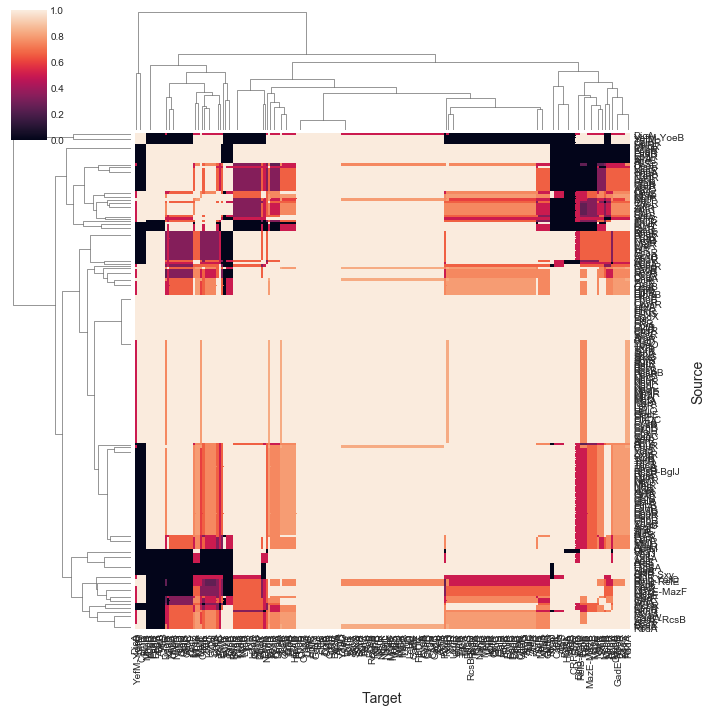

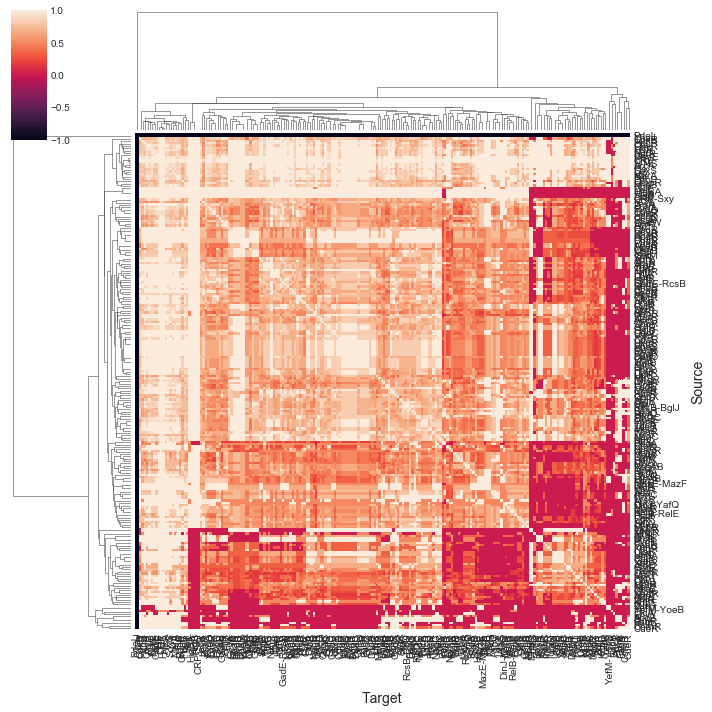

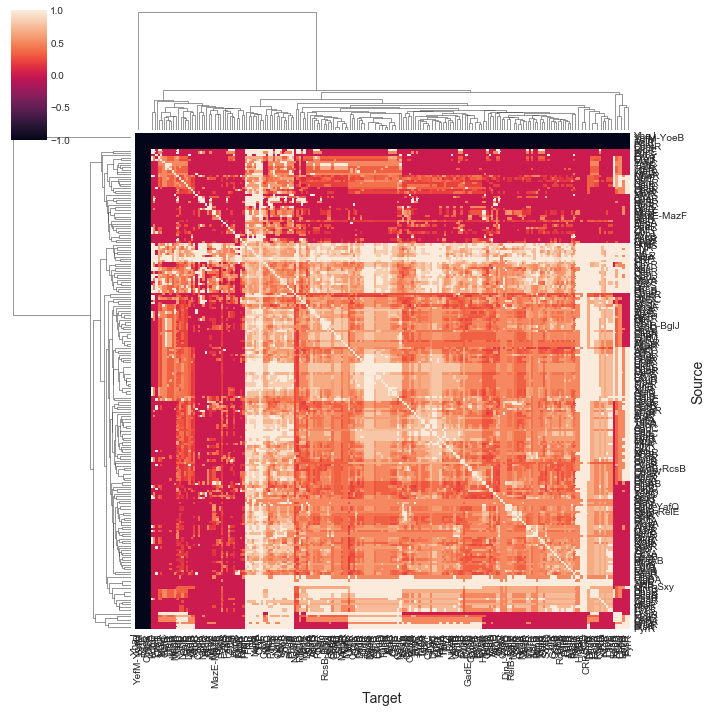

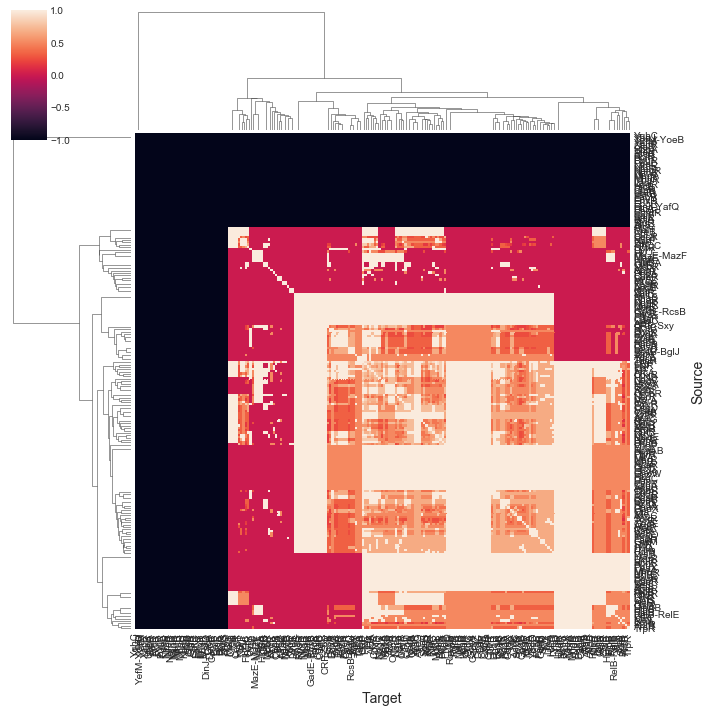

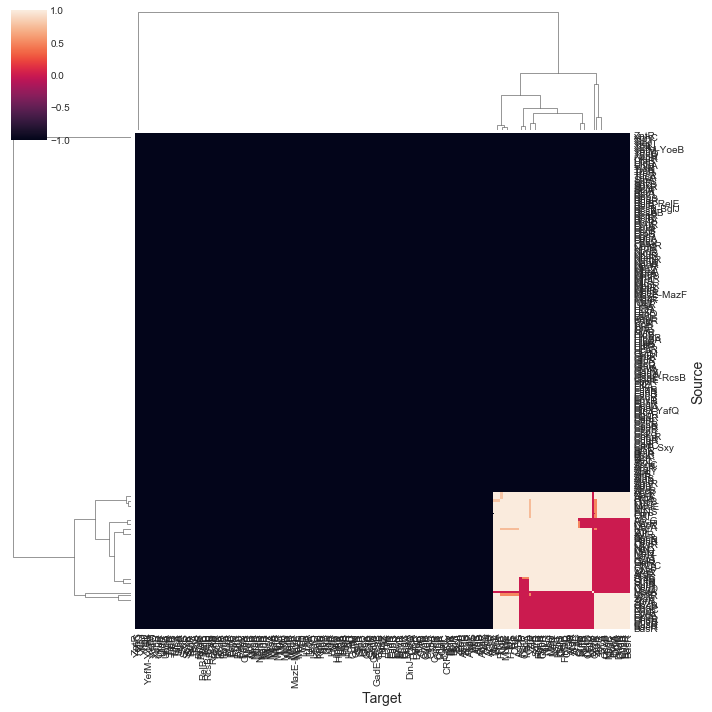

In [23]:
for matrix_label in matrix_labels:
    clustermap(modified_jaccard[matrix_label])